In [2]:
%reset
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from fooof import FOOOF

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']


def rmse(preds, target):
    """Calculate root mean squared error."""
    
    return np.sqrt(((preds - target) ** 2).mean())

def abs_err_freq(preds, target):
    """Calculate the absolute error across frequencies."""
    
    return np.abs(preds - target)

def data_ecog2(chandat, srate, channel):
    # make the PSD
    window_size = int(srate*10)
    overlap = int(window_size * 0.5)

    xf, _, psd_array = signal.spectrogram(chandat, fs=srate, window=('hanning'), nperseg=window_size, noverlap=overlap)
    psd_array = np.log10(psd_array)

    return psd_array,xf

import os
my_dir = '/Users/Voytek/fooof/data'

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# # syn
# file = 'syn/6.npy'
# filename = os.path.join(my_dir, file)
# freq_range = [3, 50]
# psd_array = np.load(filename)
# psd_array = np.log10(psd_array)
# range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
# freqs = np.linspace(freq_range[0], freq_range[1], range_size)-1
# # Fix up PSD
# psd_array = np.vstack((psd_array, psd_array))

# # real eeg
# file = '10.csv'
# filename = os.path.join(my_dir, file)
# chandat = np.loadtxt(filename, delimiter=',')
# if np.shape(chandat)[0]<np.shape(chandat)[1]:
#     chandat = chandat.T
# channels = np.shape(chandat)[1]
# ci = 61
# srate = 256.
# tempdat = chandat[:, ci]
# psd_array, freqs = data_ecog2(tempdat, srate, ci)

# # eeg
# file = 'eeg/22.npy'
# filename = os.path.join(my_dir, file)
# freq_range = [0, 50]
# psd_array = np.load(filename)
# psd_array = np.log10(psd_array)
# psd_array = np.mean(psd_array,0)
# range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
# freqs = np.linspace(freq_range[0], freq_range[1], range_size)
# f_range = [2, 35]

# # lfp
file = 'lfp/g1018_ch03_raw.npy'
filename = os.path.join(my_dir, file)
freq_range = [0, 50]
psd_array = np.load(filename)
psd_array = np.log10(psd_array)
psd_array = np.mean(psd_array,0)
range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
freqs = np.linspace(freq_range[0], freq_range[1], range_size)
f_range = [2, 45]

# # Run FOOOF
ff = FOOOF()
f_range = [3, 40]
%time ff.fit(freqs, psd_array, f_range)


CPU times: user 22.4 ms, sys: 1.74 ms, total: 24.1 ms
Wall time: 23.2 ms


In [77]:
def decision_criterion(amp_params, bw_params):
    foo = (np.divide(bw_params,amp_params))
    print(foo)
    keep_parameter = foo < 20
        

    return keep_parameter


osc_params = group_three(oscillation_params)
amp_params = [item[1] for item in osc_params]
bw_params = [item[2] for item in osc_params]
keep_osc = decision_criterion(amp_params, bw_params)
guess = [d for (d, remove) in zip(osc_params, keep_osc) if remove]

print(guess)



[  5.82518404   1.05897823  12.40974113  11.16806159]
[[5.9278171276189022, 0.24621573293273058, 1.4342519575406436], [10.213415177935522, 1.5312606886836548, 1.6215717329144699], [14.327020694953051, 0.12581976754182411, 1.5613907438255301], [19.306959133550137, 0.15763574439835124, 1.7604857026484821]]


CPU times: user 117 ms, sys: 626 µs, total: 117 ms
Wall time: 60.1 ms


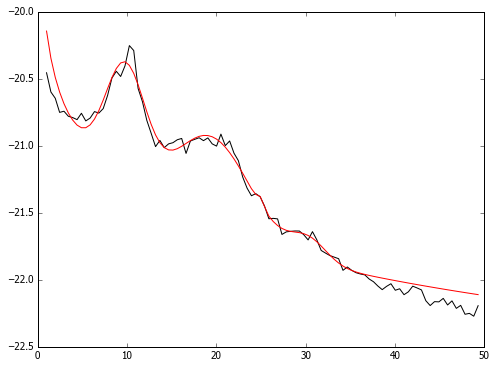

[ -2.01548741e+01  -1.15505074e+00   3.31599259e-25]
[  9.77898626   0.86685477   3.20091149  19.4921793    0.7140612
   6.17443464  24.98914139   0.05569687   0.5         30.3112987
   0.16325199   2.88260015]


In [32]:
# OR: load MEG data from npy file

dat = np.load('meg_dat.npy')

freqs = dat[0]
psd = dat[1]

# Set which PSD to run
cur_psd = psd[0, :]

# Fix up PSD
psd_array = np.log10(cur_psd)
psd_array = np.vstack((psd_array, psd_array))
psd_array = psd_array.T

# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 6
cut_freqs = [1, 50]
bw_limits = [0.5, 8]

# Run FOOOF
%time p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.show()
print(background_params)
print(oscillation_params)

In [71]:
# LFP

import os

# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 5
cut_freqs = [2, 45]
bw_limits = [0.5, 6]

col_cf = []
col_bw = []
col_file = []
my_dir = '/Users/Voytek/fooof/data/lfp'
for file in os.listdir(my_dir):
    if file.endswith('.npy'):
        # lfp
        filename = os.path.join(my_dir, file)
        freq_range = [0, 49]
        psd_array = np.load(filename)
        psd_array = np.log10(psd_array)
        range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
        freqs = np.linspace(freq_range[0], freq_range[1], range_size)
        # Fix up PSD
        psd_array = np.vstack((psd_array, psd_array))
        psd_array = psd_array.T

        # Run FOOOF
        p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
            fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)
        
        if np.any(oscillation_params):
            oscillation_params = group_three(oscillation_params)
            
            
            
            
            amp_params = [item[1] for item in oscillation_params]
            bw_params = [item[2] for item in oscillation_params]
            keep_osc = decision_criterion(amp_params, bw_params)
            oscillation_params = [d for (d, remove) in zip(oscillation_params, keep_osc) if remove]

            
            
            
            
            for i in range(np.shape(oscillation_params)[0]):
                col_cf.append(oscillation_params[i][0])
                col_bw.append(oscillation_params[i][2])
                col_file.append(file)
        else:
            col_cf.append(0)
            col_bw.append(0)
            col_file.append(file)     

import pandas as pd
d = {'file': col_file, 'cf': col_cf, 'bw': col_bw}
df = pd.DataFrame(data=d)
df = df[['file', 'cf', 'bw']]
df.to_csv('lfp.csv', sep=',', index = False)

In [80]:
# EEG

import os

# FOOOF SETTINGS
window_around_max = 3
number_of_gaussians = 5
cut_freqs = [2, 35]
bw_limits = [1, 6]

col_cf = []
col_bw = []
col_file = []
my_dir = '/Users/Voytek/fooof/data/eeg'
for file in os.listdir(my_dir):
    if file.endswith('.npy'):
        # eeg
        filename = os.path.join(my_dir, file)
        freq_range = [0, 49]
        psd_array = np.load(filename)
        psd_array = np.log10(psd_array)
        range_size = (np.size(range(freq_range[1]))-0)-(np.size(range(freq_range[0]))+0)
        freqs = np.linspace(freq_range[0], freq_range[1], range_size)
        # Fix up PSD
        psd_array = np.vstack((psd_array, psd_array))
        psd_array = psd_array.T
        
        # Run FOOOF
        p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
            fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)
        
        if np.any(oscillation_params):
            oscillation_params = group_three(oscillation_params)

            for i in range(np.shape(oscillation_params)[0]):
                col_cf.append(oscillation_params[i][0])
                col_bw.append(oscillation_params[i][2])
                col_file.append(file)
        else:
            col_cf.append(0)
            col_bw.append(0)
            col_file.append(file)

import pandas as pd
d = {'file': col_file, 'cf': col_cf, 'bw': col_bw}
df = pd.DataFrame(data=d)
df = df[['file', 'cf', 'bw']]
df.to_csv('eeg.csv', sep=',', index = False)

In [ ]:
from scipy import stats

eeg = pd.read_csv('fits/eeg.csv', sep=',')
# plt.scatter(eeg[['cf']], eeg[['bw']], color='b')

lfp = pd.read_csv('fits/lfp.csv', sep=',')
# plt.scatter(lfp[['cf']], lfp[['bw']], color='g')
# plt.show()

frames = [lfp]

df = pd.concat(frames)

df = df[df['bw'] < 8]
df = df[df['bw'] > 0.5]
df = df[df['cf'] < 50]

plt.scatter(df[['cf']], df[['bw']])
plt.show()

r,p = stats.pearsonr(df[['cf']], df[['bw']])
r,p

In [ ]:
# real eeg

import os
from fooof.dat import data_ecog
import pandas as pd


col_cf = []
col_bw = []
col_amp = []
col_offset = []
col_slope = []
col_curve = []
col_chan = []
col_file = []

srate = 256.
# FOOOF SETTINGS
window_around_max = 4
number_of_gaussians = 6
cut_freqs = [2, 30]
bw_limits = [0.5, 8]

my_dir = '/Users/Voytek/fooof/data'
for file in os.listdir(my_dir):
    if file.endswith('.csv'):
        filename = os.path.join(my_dir, file)

        chandat = np.loadtxt(filename, delimiter=",")
        if np.shape(chandat)[0]<np.shape(chandat)[1]:
            chandat = chandat.T
        
        channels = np.shape(chandat)[1]
        
        for ci in range(channels):
            tempdat = chandat[:, ci]
            psd_array, freqs = data_ecog2(tempdat, srate, ci)


            # Run FOOOF
            p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
                fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

            if np.any(oscillation_params):
                oscillation_params = group_three(oscillation_params)

                for i in range(np.shape(oscillation_params)[0]):
                    col_cf.append(oscillation_params[i][0])
                    col_amp.append(oscillation_params[i][1])
                    col_bw.append(oscillation_params[i][2])
                    col_offset.append(background_params[0])
                    col_slope.append(background_params[2])
                    col_curve.append(background_params[1])
                    col_chan.append(ci)
                    col_file.append(file)
            else:
                col_cf.append(0)
                col_amp.append(0)
                col_bw.append(0)
                col_offset.append(background_params[0])
                col_slope.append(background_params[2])
                col_curve.append(background_params[1])
                col_chan.append(ci)
                col_file.append(file)


d = {'file': col_file, 'cf': col_cf, 'bw': col_bw, 'amp': col_amp, 'offset': col_offset, 'slope': col_slope, 'curve': col_curve, 'chan': col_chan}
df = pd.DataFrame(data=d)
df = df[['file', 'chan', 'cf', 'bw', 'amp', 'offset', 'slope', 'curve']]
df.to_csv('real_eeg.csv', sep=',', index = False)


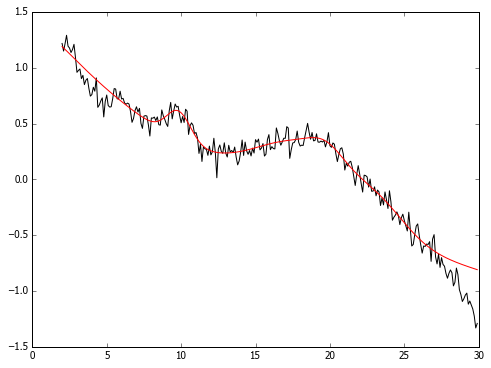

[  1.27747987e+00  -9.66150585e-18  -9.58773125e-01]
[ 19.79807788   0.13566692   1.62650247  23.3628401    0.2026741
   2.60628783  18.33338336   0.55681895   4.64083126   9.84174738
   0.26074297   1.16012291]


In [35]:
# real eeg

import os
from fooof.dat import data_ecog
import pandas as pd


col_cf = []
col_bw = []
col_amp = []
col_offset = []
col_slope = []
col_curve = []
col_chan = []
col_file = []

srate = 256.
# FOOOF SETTINGS
window_around_max = 4
number_of_gaussians = 6
cut_freqs = [2, 30]
bw_limits = [0.5, 10]

filename = os.path.join('/Users/Voytek/fooof/data/6.csv')

chandat = np.loadtxt(filename, delimiter=",")
if np.shape(chandat)[0]<np.shape(chandat)[1]:
    chandat = chandat.T

channels = np.shape(chandat)[1]

ci=46

tempdat = chandat[:, ci]
psd_array, freqs = data_ecog2(tempdat, srate, ci)


# Run FOOOF
p_flat_real, frequency_vector, trimmed_psd, psd_fit, background_fit, gaussian_fit, background_params, oscillation_params = \
    fooof(freqs, psd_array, cut_freqs, number_of_gaussians, window_around_max, bw_limits)

plt.plot(frequency_vector, trimmed_psd, 'k')
plt.plot(frequency_vector, psd_fit, 'r')
plt.show()
print(background_params)
print(oscillation_params)

In [ ]:
from scipy import stats
import pandas as pd

df = pd.read_csv('real_eeg.csv', sep=',')


df = df[df['bw'] < 5]
df = df[df['bw'] > 0.5]
df = df[df['cf'] < 35]
df = df[df['slope'] > -5]
df = df[df['slope'] < 0]

plt.scatter(df[['cf']], df[['bw']])
plt.show()

r,p = stats.pearsonr(df[['cf']], df[['bw']])
r,p